In [8]:
#Implicit_opt

In [9]:
import sys
sys.path.append("..")
from geomatry.opt.scipy_optimizer import SingleSystemOptimizer
from geomatry.opt_Energy_approximated.optimizer import SingleSystemOptimizer as SingleSystemOptimizer_Energy
from geomatry.opt.loss import rmsd_loss
from geomatry.ff.graph import get_given_graph_builder
from geomatry.ff.springs import SpringFF, _random_spring_system, _random_spring_ff_param
import torch
import copy

N = 50
N_pairs = 200
max_Za = 3
Ra, Za, idx_i, idx_j = _random_spring_system(N, N_pairs, max_Za, start_Za=1)
k, r0 = _random_spring_ff_param(max_Za, r0_max=5, k_max=5)
ff = SpringFF(max_Za)
ff.reset_parameters(k, r0)

fixed_atom_indices = [0, 1, 2]
graph_builder = get_given_graph_builder(idx_i, idx_j)

# start implicit optimization
params_star = ff.state_dict()
print("params_star", params_star)
optimizer = SingleSystemOptimizer(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)

optimizer_Energy = SingleSystemOptimizer_Energy(
    Ra, Za, graph_builder, ff, rmsd_loss, 
    params_star=params_star,
    fixed_atom_indices=fixed_atom_indices,
    fmax=1e-5
)

k_perturbed = torch.clamp(k.clone() + torch.randn_like(k) * 0.1, min=0)
r0_perturbed = torch.clamp(r0.clone() + torch.randn_like(r0) * 0.1, min=0)
ff.reset_parameters(k_perturbed, r0_perturbed)
params_0 = ff.state_dict()
params_0_old = copy.deepcopy(params_0)
print("params_0", params_0)
new_params_0=optimizer.optimize(params_0)
print("params_optimized",new_params_0)

params_star OrderedDict([('k', tensor([[2.4661, 2.0175, 3.5836, 1.4168],
        [2.0175, 4.0092, 2.8899, 2.6678],
        [3.5836, 2.8899, 1.7532, 3.4600],
        [1.4168, 2.6678, 3.4600, 2.4586]], dtype=torch.float64)), ('r0', tensor([[0.7614, 1.8000, 3.7457, 1.3741],
        [1.8000, 2.8500, 2.9363, 3.8297],
        [3.7457, 2.9363, 4.2066, 2.8563],
        [1.3741, 3.8297, 2.8563, 0.2516]], dtype=torch.float64))])
params_0 OrderedDict([('k', tensor([[2.4843, 1.8801, 3.6566, 1.4289],
        [1.8801, 3.9342, 2.9665, 2.7705],
        [3.6566, 2.9665, 1.7528, 3.4891],
        [1.4289, 2.7705, 3.4891, 2.5468]], dtype=torch.float64)), ('r0', tensor([[0.7451, 1.7957, 3.7108, 1.4413],
        [1.7957, 2.7443, 2.9619, 3.8211],
        [3.7108, 2.9619, 4.1864, 2.9490],
        [1.4413, 3.8211, 2.9490, 0.5432]], dtype=torch.float64))])
loss: 0.839125150941728
loss: 2.641976117976667
loss: 0.6881069349294375
loss: 0.5507122737453563
loss: 1.0439846031521938
loss: 0.3387946768721674
loss: 0.2

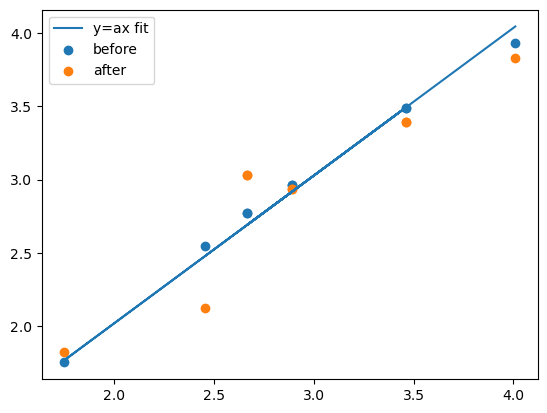

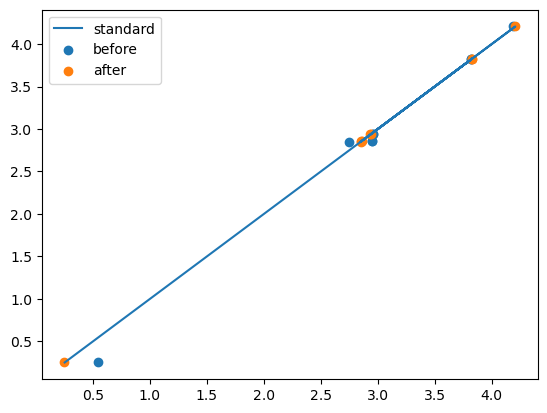

In [10]:
#Confirm
import matplotlib.pyplot as plt

new_params_0['k']=(new_params_0['k']+new_params_0['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_0_old['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(new_params_0['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

In [11]:
#Energy landscape opt

params_0 OrderedDict([('k', tensor([[2.4843, 1.8801, 3.6566, 1.4289],
        [1.8801, 3.9342, 2.9665, 2.7705],
        [3.6566, 2.9665, 1.7528, 3.4891],
        [1.4289, 2.7705, 3.4891, 2.5468]], dtype=torch.float64)), ('r0', tensor([[0.7451, 1.7957, 3.7108, 1.4413],
        [1.7957, 2.7443, 2.9619, 3.8211],
        [3.7108, 2.9619, 4.1864, 2.9490],
        [1.4413, 3.8211, 2.9490, 0.5432]], dtype=torch.float64))])
loss: 0.839125150941728
0.839125150941728


  0%|          | 0/1001 [00:00<?, ?it/s]

0 4.779339267321191 tensor(1302.0605, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(1.3209, dtype=torch.float64, grad_fn=<MaxBackward1>)


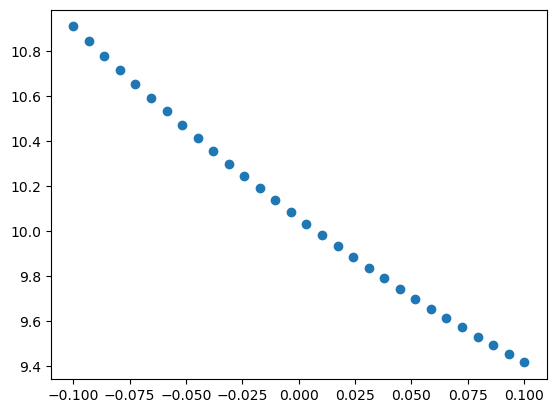

  2%|▏         | 20/1001 [00:02<01:19, 12.29it/s]

loss: 0.8357115069906931


 98%|█████████▊| 976/1001 [00:04<00:00, 388.86it/s]

1000 9.807860170880566 tensor(0.0444, dtype=torch.float64, grad_fn=<AddBackward0>) 0


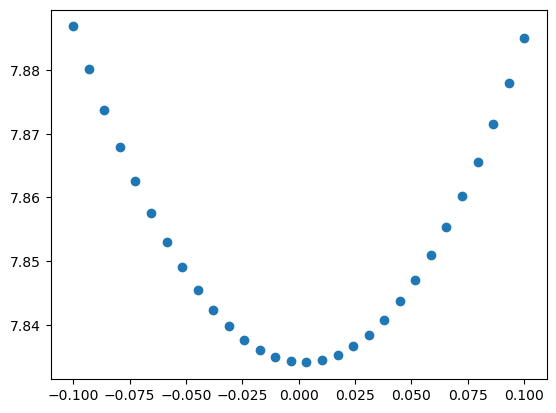

100%|██████████| 1001/1001 [00:04<00:00, 202.60it/s]

loss: 0.0003599619947154412
final OrderedDict([('k', tensor([[2.4843, 1.8801, 3.6566, 1.4289],
        [1.8801, 3.8809, 2.8215, 2.5994],
        [3.6566, 2.8215, 1.7093, 3.3776],
        [1.4289, 2.5994, 3.3776, 2.4118]], dtype=torch.float64)), ('r0', tensor([[0.7451, 1.7957, 3.7108, 1.4413],
        [1.7957, 2.8502, 2.9365, 3.8293],
        [3.7108, 2.9365, 4.2067, 2.8563],
        [1.4413, 3.8293, 2.8563, 0.2532]], dtype=torch.float64))])


In [12]:
def energyAndRsquare(k_perturbed, r0_perturbed, optimizer):
    ff.reset_parameters(k_perturbed, r0_perturbed)
    params_0 = ff.state_dict()
    print("params_0", params_0)
    for i in range(1):
        params_0=optimizer.optimize(params_0, 1001, 1000, 0.1, 6, 2)
    return params_0
new_params_0_Energy=energyAndRsquare(k_perturbed, r0_perturbed, optimizer_Energy)


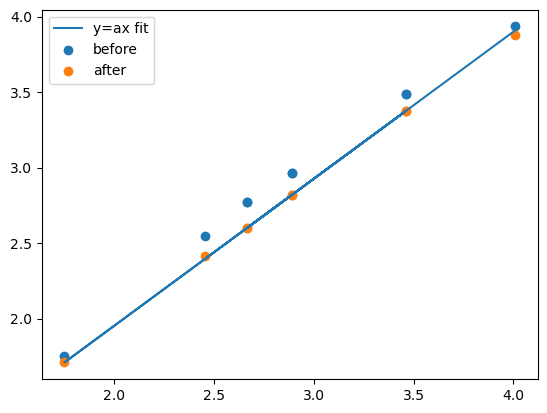

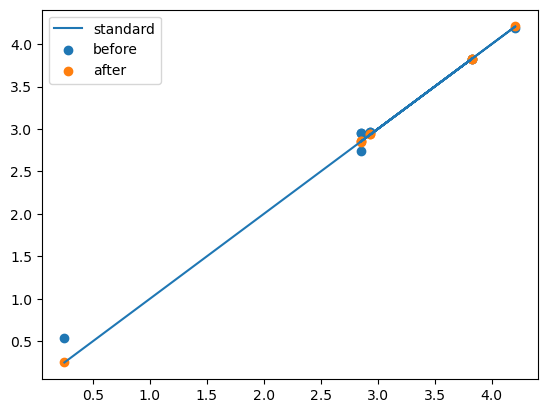

In [14]:
#Confirm
import matplotlib.pyplot as plt

new_params_0_Energy['k']=(new_params_0_Energy['k']+new_params_0_Energy['k'].T)/2
params_star['k']=(params_star['k']+params_star['k'].T)/2
params_0_old['k']=(params_0_old['k']+params_0_old['k'].T)/2

a=torch.sum(new_params_0_Energy['k'][1:,1:].reshape(-1))/torch.sum(params_star['k'][1:,1:].reshape(-1))
plt.plot(params_star['k'][1:,1:].reshape(-1),a*params_star['k'][1:,1:].reshape(-1),label='y=ax fit')
plt.scatter(params_star['k'][1:,1:].reshape(-1),params_0_old['k'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['k'][1:,1:].reshape(-1),new_params_0_Energy['k'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()

#Compare
import matplotlib.pyplot as plt

plt.plot(params_star['r0'][1:,1:].reshape(-1),params_star['r0'][1:,1:].reshape(-1),label='standard')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),params_0_old['r0'][1:,1:].reshape(-1),label='before')
plt.scatter(params_star['r0'][1:,1:].reshape(-1),new_params_0_Energy['r0'][1:,1:].reshape(-1),label='after')
plt.legend()
plt.show()